In [1]:
# 1. Create a massive list of possible activation functions
# 2. Iteratively create a graph for the target network using random activations and connectivity
# 3. See how well neural networks of different sizes and activation functions can solve it
#    Here I'm really just looking for diversity in the solutions.
# 4. Then try the same thing, but connect all hidden units to the output.
# 5. Try the same thing, but use all of the hidden units generated by all units.


# Progression of things to look at:
# - Initializations
# - Activations
# - Sparsity
# - Small world sparsity

In [2]:
import random
from typing import Any, Dict, List, Optional, Type, Tuple

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sparselinear as sl
import torch
from torch import nn
import torch.optim as optim
from torch.nn import functional as F

from phd.feature_search.core.idbd import IDBD
from phd.feature_search.core.models.base import LTU, FTA
from phd.feature_search.core.experiment_helpers import StandardizationStats, standardize_targets

In [3]:
class SinActivation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.sin(x)
    
class NormActivation(nn.Module):
    def __init__(self, decay_rate: float = 0.99):
        super().__init__()
        self.stats = StandardizationStats(gamma=decay_rate)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out, self.stats = standardize_targets(x, self.stats)
        return out

In [4]:
activation_functions = {
    'relu': nn.ReLU,
    'sigmoid': nn.Sigmoid,
    'tanh': nn.Tanh,
    'elu': nn.ELU,
    'leaky_relu': nn.LeakyReLU,
    'swish': nn.SiLU,
    'gelu': nn.GELU,
    'selu': nn.SELU,
    'softplus': nn.Softplus,
    'softsign': nn.Softsign,
    'linear': nn.Identity,
    'ltu': LTU,
    'fta': FTA,
    'sin': SinActivation,
    'norm': NormActivation,
}

In [5]:
class RandomNetwork(nn.Module):
    def __init__(
        self,
        input_dim: int,
        n_hidden_activations: int,
        activation_functions: Dict[str, Type[nn.Module]],
    ):
        super().__init__()
        self.input_dim = input_dim
        self.n_hidden_activations = n_hidden_activations
        self.activation_functions = activation_functions
        self.max_connections_per_node = input_dim // 2
        
        self.activations, self.node_input_ids = self._generate_random_network(
            input_dim, n_hidden_activations, self.max_connections_per_node, activation_functions)
        
        n_inputs_per_node = torch.tensor([len(ids) for ids in self.node_input_ids])
        bounds = torch.sqrt(3 / n_inputs_per_node).reshape(n_hidden_activations, 1, 1) # Kaiming uniform
        self.weights = torch.rand(n_hidden_activations, 1, self.max_connections_per_node) * 2 * bounds - bounds
        self.weights = nn.Parameter(self.weights)
    
    def _generate_random_network(
        self,
        input_dim: int,
        n_hidden_activations: int,
        max_connections_per_node: int,
        activation_functions: Dict[str, Type[nn.Module]],
    ) -> Tuple[List[nn.Module], List[List[int]]]:
        """Generates a random network structure with specified input dimension and number of hidden activations.
        
        Args:
            input_dim: Number of input dimensions
            n_hidden_activations: Number of hidden activation nodes to generate
            activation_functions: Dictionary mapping activation names to activation classes
            
        Returns:
            Tuple containing:
                - List of activation modules
                - List of input indices for each activation node
        """
        n_hidden_units = input_dim
        activations = []
        node_input_ids = []
        
        for i in range(n_hidden_activations):
            activation_type = random.choice(list(activation_functions.keys()))
            n_inputs = random.randint(1, input_dim)
            if activation_type == 'fta':
                activations.append(FTA(1))
                n_outputs = 20
            else:
                activations.append(activation_functions[activation_type]())
                n_outputs = 1
            
            n_connections = random.randint(1, max_connections_per_node)
            input_ids = random.sample(range(n_hidden_units), n_connections)
            node_input_ids.append(input_ids)
            n_hidden_units += n_outputs
            
        return activations, node_input_ids

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        all_values = inputs.clone() # (batch_size, input_dim)
        for i, activation in enumerate(self.activations):
            values = all_values[:, self.node_input_ids[i]] # (batch_size, n_node_inputs)
            weights = self.weights[i, :, :values.shape[1]] # (1, n_node_inputs)
            preactivation = values @ weights.T # (batch_size, 1)
            postactivation = activation(preactivation)
            all_values = torch.cat([all_values, postactivation], dim=1)
        print(all_values.shape)
        return all_values

In [6]:
def create_mlp(
    layer_sizes: List[int],
    activation_class: Type[nn.Module],
    sparsity_rate: float = 0.0,
    small_world_sparsity: bool = False,
    bias: bool = True,
    seed: Optional[int] = None,
) -> nn.Sequential:
    """Create a Multi-Layer Perceptron (MLP) with specified architecture.
    
    Args:
        layer_sizes: List of integers representing the size of each layer,
            including input and output layers. For example, [784, 128, 64, 10]
            creates a network with input size 784, two hidden layers of 128 and 64
            neurons, and output size 10.
        activation_class: PyTorch activation function class (e.g., nn.ReLU,
            nn.Tanh, nn.Sigmoid, nn.LeakyReLU).
        sparsity_rate: The sparsity rate to apply to the linear layers.
        bias: Whether to include bias terms in linear layers.
        seed: Optional random seed for reproducibility.
    
    Returns:
        nn.Sequential: A PyTorch Sequential model representing the MLP.
    
    Raises:
        ValueError: If layer_sizes has fewer than 2 elements (input and output).
        ValueError: If any layer size is not positive.
    """
    if len(layer_sizes) < 2:
        raise ValueError(
            "layer_sizes must contain at least 2 elements (input and output)"
        )
    
    if any(size <= 0 for size in layer_sizes):
        raise ValueError("All layer sizes must be positive integers")
    
    if seed is not None:
        torch.manual_seed(seed)
    
    layers = []
    
    for i in range(len(layer_sizes) - 1):
        # Add linear layer
        if sparsity_rate > 0:
            new_layer = sl.SparseLinear(
                in_features = layer_sizes[i],
                out_features = layer_sizes[i + 1],
                bias = bias and i < len(layer_sizes) - 2,
                sparsity = sparsity_rate,
                small_world = small_world_sparsity,
            )
        else:
            new_layer = nn.Linear(
                in_features = layer_sizes[i],
                out_features = layer_sizes[i + 1],
                bias = bias and i < len(layer_sizes) - 2,
            )
        
        layers.append(new_layer)
        
        # Add activation function (except for the last layer)
        if i < len(layer_sizes) - 2:
            layers.append(activation_class())
    
    return nn.Sequential(*layers)

In [7]:
def train_model(
    model: nn.Module,
    train_inputs: torch.Tensor,
    train_outputs: torch.Tensor,
    repr_step_size: float,
    batch_size: int,
    print_freq: int = 1000,
    log_freq: int = 1000,
) -> Tuple[List[float], List[float]]:
    """Train a model and return training and test losses."""
    # output_optimizer = IDBD(
    #     params = model[-1].parameters(),
    #     meta_lr = 0.005,
    #     init_lr = 0.01,
    #     version = 'squared_grads',
    #     autostep = True,
    # )
    # if len(model) > 1:
    repr_optimizer = optim.Adam(model.parameters(), lr=repr_step_size)
    # else:
    #     repr_optimizer = None
    
    train_losses = []
    errors = []
    
    n_train_batches = len(train_inputs) // batch_size
    
    running_train_loss = 0.0
    print_loss_sum = 0.0
    step = 0
    
    for step in range(n_train_batches):
        # Get batch
        start_idx = step * batch_size
        end_idx = start_idx + batch_size
            
        batch_inputs = train_inputs[start_idx:end_idx]
        batch_outputs = train_outputs[start_idx:end_idx]
        
        outputs = model(batch_inputs)
        loss = F.mse_loss(outputs, batch_outputs)
        
        with torch.no_grad():
            batch_errors = (batch_outputs - outputs).view(-1).tolist()
            errors.extend(batch_errors)
        
        # Backward pass
        # output_optimizer.zero_grad()
        if repr_optimizer is not None:
            repr_optimizer.zero_grad()
        
        loss.backward() # retain_graph=True)
        
        # output_optimizer.step(outputs)
        if repr_optimizer is not None:
            repr_optimizer.step()
        
        # Accumulate running loss
        running_train_loss += loss.item()
        print_loss_sum += loss.item()
        
        if (step + 1) % print_freq == 0:
            print(f"Step {step+1}: Loss = {print_loss_sum / print_freq:.6f}")
            print_loss_sum = 0.0
        
        # Log periodically
        if (step + 1) % log_freq == 0:
            # Calculate average training loss
            avg_train_loss = running_train_loss / log_freq
            train_losses.append(avg_train_loss)
            
            # Reset running stats
            running_train_loss = 0.0
    
    return {
        'losses': train_losses,
        'errors': errors,
    }

In [8]:
def plot_1var_ablation_results(
    results_dict: Dict[Any, Dict[str, List[float]]],
    ablation_variable: str,
    figsize: Tuple[int, int] = (10, 6)
):
    """Plot training curves comparing different values of a single ablated variable.
    
    Args:
        results_dict: Dictionary mapping ablation values to results_dict containing
            'losses' list
        ablation_variable: Name of the variable that was ablated
        figsize: Figure size (width, height) in inches
    """
    # Extract unique ablation values
    ablation_values = sorted(list(results_dict.keys()))
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Define colors for different ablation values
    colors = plt.cm.Set1(np.linspace(0, 1, len(ablation_values)))
    
    # Find global min and max for consistent axis limits
    all_losses = []
    for result in results_dict.values():
        all_losses.extend(result['losses'])

    y_min = min(all_losses)
    y_max = max(all_losses)

    # Add padding to y-axis, using multiplicative padding for log scale
    y_min = y_min / 1.5  # Divide by >1 to extend lower bound
    y_max = y_max * 1.1  # Multiply by >1 to extend upper bound

    # Get number of steps from first result's losses length
    n_steps = len(next(iter(results_dict.values()))['losses'])
    steps = list(range(1, n_steps + 1))

    # Plot each ablation value with a different color
    for i, ablation_val in enumerate(ablation_values):
        result = results_dict[ablation_val]
        losses = result['losses']
        
        ax.plot(steps, losses, 
                label=f'{ablation_variable}={ablation_val}', 
                color=colors[i], 
                alpha=0.8,
                linewidth=2)
    
    ax.set_xlabel('Step')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training Loss vs {ablation_variable}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Set y-axis to log scale
    ax.set_yscale('log')
    
    # Set consistent axis limits
    ax.set_ylim(y_min, y_max)
    ax.set_xlim(1, n_steps)

    plt.tight_layout()
    plt.show()

    # Print final results summary
    print("\nFinal Results Summary:")
    print("=" * 50)
    for ablation_val in ablation_values:
        result = results_dict[ablation_val]
        final_loss = result['losses'][-1]
        print(f"{ablation_variable}={ablation_val}  --  Final Loss: {final_loss:.6f}")


def plot_2var_ablation_results(
    results_dict: Dict[Tuple[Any, Any], Dict[str, List[float]]],
    row_variable: str,
    col_variable: str,
    figsize: Tuple[int, int] = (15, 12)
):
    """Plot a grid of training curves comparing different model configurations.
    
    Args:
        results_dict: Dictionary mapping (row_val, col_val) tuples to results_dict containing
            'train_losses' and 'test_losses' lists
        row_variable: Name of the variable that varies across rows
        col_variable: Name of the variable that varies across columns
        figsize: Figure size (width, height) in inches
    """
    # Extract unique values for rows and columns
    row_values = sorted(list({r for r, _ in results_dict.keys()}))
    col_values = sorted(list({c for _, c in results_dict.keys()}))
    
    # Create figure and axes grid
    fig, axes = plt.subplots(
        len(row_values), len(col_values),
        figsize=figsize, sharex=True, sharey=True
    )
    
    # Ensure axes is always 2D
    if len(row_values) == 1:
        axes = axes.reshape(1, -1)
    if len(col_values) == 1:
        axes = axes.reshape(-1, 1)

    # Find global min and max for consistent axis limits
    all_losses = []
    for result in results_dict.values():
        all_losses.extend(result['losses'])

    y_min = min(all_losses)
    y_max = max(all_losses)

    # Add padding to y-axis, using multiplicative padding for log scale
    y_min = y_min / 1.5  # Divide by >1 to extend lower bound
    y_max = y_max * 1.1  # Multiply by >1 to extend upper bound

    # Get number of steps from first result's losses length
    n_steps = len(next(iter(results_dict.values()))['losses'])
    steps = list(range(1, n_steps + 1))

    for i, row_val in enumerate(row_values):
        for j, col_val in enumerate(col_values):
            ax = axes[i, j]
            
            result = results_dict[(row_val, col_val)]
            losses = result['losses']
            
            ax.plot(steps, losses, label='Loss', color='blue', alpha=0.7)
            
            ax.set_title(f'{row_variable}={row_val}, {col_variable}={col_val}')
            ax.set_xlabel('Step')
            ax.set_ylabel('Loss')
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            # Set y-axis to log scale
            ax.set_yscale('log')
            
            # Set consistent axis limits
            ax.set_ylim(y_min, y_max)
            ax.set_xlim(1, n_steps)

    plt.tight_layout()
    plt.show()

    # Print final results summary
    print("\nFinal Results Summary:")
    print("=" * 50)
    for row_val in row_values:
        for col_val in col_values:
            result = results_dict[(row_val, col_val)]
            final_loss = result['losses'][-1]
            print(f"{row_variable}={row_val}, {col_variable}={col_val}  --  Final Loss: {final_loss:.6f}")

In [9]:
def plot_1var_error_correlations(
    results_dict: Dict[Any, Dict[str, List[float]]],
    ablation_variable: str,
    figsize: Tuple[int, int] = (8, 6)
) -> None:
    """Plot a heatmap showing correlations between error sequences for different ablation values.
    
    Args:
        results_dict: Dictionary mapping ablation values to results containing 'errors' lists
        ablation_variable: Name of the variable that was ablated
        figsize: Figure size (width, height) in inches
    """
    # Create labels for each configuration
    configs = []
    error_sequences = []
    
    for ablation_val in results_dict.keys():
        configs.append(f"{ablation_variable}={ablation_val}")
        error_sequences.append(results_dict[ablation_val]['errors'])
    
    n_configs = len(configs)
    correlations = np.zeros((n_configs, n_configs))
    
    # Compute pairwise correlations
    for i in range(n_configs):
        for j in range(n_configs):
            corr = np.corrcoef(error_sequences[i], error_sequences[j])[0,1]
            correlations[i,j] = corr
            
    # Create heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(
        correlations,
        xticklabels=configs,
        yticklabels=configs,
        vmin=0,
        vmax=1,
        cmap='viridis',
        annot=True,
        fmt='.2f'
    )
    
    plt.title(f'Pairwise Error Sequence Correlations - {ablation_variable}')
    plt.tight_layout()
    plt.show()


def plot_2var_error_correlations(
    results_dict: Dict[Tuple[Any, Any], Dict[str, List[float]]],
    row_variable: str,
    col_variable: str,
    figsize: Tuple[int, int] = (10, 8)
) -> None:
    """Plot a heatmap showing correlations between error sequences for different model configs.
    
    Args:
        results_dict: Dictionary mapping (row_val, col_val) tuples to results containing 'errors' lists
        row_variable: Name of the variable that varies across rows 
        col_variable: Name of the variable that varies across columns
        figsize: Figure size (width, height) in inches
    """
    # Create labels for each configuration
    configs = []
    error_sequences = []
    
    for row_val, col_val in results_dict.keys():
        configs.append(f"{row_variable}={row_val}\n{col_variable}={col_val}")
        error_sequences.append(results_dict[(row_val, col_val)]['errors'])
    
    n_configs = len(configs)
    correlations = np.zeros((n_configs, n_configs))
    
    # Compute pairwise correlations
    for i in range(n_configs):
        for j in range(n_configs):
            corr = np.corrcoef(error_sequences[i], error_sequences[j])[0,1]
            correlations[i,j] = corr
            
    # Create heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(
        correlations,
        xticklabels=configs,
        yticklabels=configs,
        vmin=0,
        vmax=1,
        cmap='viridis',
        annot=True,
        fmt='.2f'
    )
    
    plt.title('Pairwise Error Sequence Correlations')
    plt.tight_layout()
    plt.show()

In [10]:
input_dim = 20
n_hidden_activations = 20

# Create a random target network
target_network = RandomNetwork(
    input_dim, n_hidden_activations, activation_functions)

n_samples = 60_000

inputs = torch.randn(n_samples, input_dim)
with torch.no_grad():
    outputs = target_network(inputs)[:, -1:]

torch.Size([60000, 59])


## Different initializatons

In [11]:
batch_size = 1

activation_cls = nn.ReLU
n_layers = 3
hidden_dim = 100
seeds = [0, 1, 2, 3, 4, 5, 6]

# Run experiments
results = {}
for seed in seeds:
    print(f"\nTraining model with seed {seed}...")
    
    # Create layer sizes
    layer_sizes = [input_dim] + [hidden_dim] * (n_layers - 1) + [outputs.shape[1]]
    # Create model
    model = create_mlp(layer_sizes, activation_cls, seed=seed)
    learning_rate = 0.02 / hidden_dim ** 0.5
    
    # Train model
    losses = train_model(
        model, inputs, outputs,
        repr_step_size = learning_rate,
        batch_size = 1,
        log_freq = 200,
        print_freq = 2000,
    )
    
    # Store results
    results[str(seed)] = losses


Training model with seed 0...
Step 2000: Loss = 0.023506
Step 4000: Loss = 0.010600
Step 6000: Loss = 0.007684
Step 8000: Loss = 0.006699
Step 10000: Loss = 0.005346
Step 12000: Loss = 0.004523
Step 14000: Loss = 0.004169
Step 16000: Loss = 0.003668
Step 18000: Loss = 0.003817
Step 20000: Loss = 0.003154
Step 22000: Loss = 0.003554
Step 24000: Loss = 0.002976
Step 26000: Loss = 0.002967
Step 28000: Loss = 0.002822
Step 30000: Loss = 0.002865
Step 32000: Loss = 0.002406
Step 34000: Loss = 0.002667
Step 36000: Loss = 0.002570
Step 38000: Loss = 0.002570
Step 40000: Loss = 0.002323
Step 42000: Loss = 0.002400
Step 44000: Loss = 0.002691
Step 46000: Loss = 0.002338
Step 48000: Loss = 0.002598
Step 50000: Loss = 0.002278
Step 52000: Loss = 0.002333
Step 54000: Loss = 0.002167
Step 56000: Loss = 0.002231
Step 58000: Loss = 0.002229
Step 60000: Loss = 0.002088

Training model with seed 1...
Step 2000: Loss = 0.023716
Step 4000: Loss = 0.010619
Step 6000: Loss = 0.007601
Step 8000: Loss = 0.0

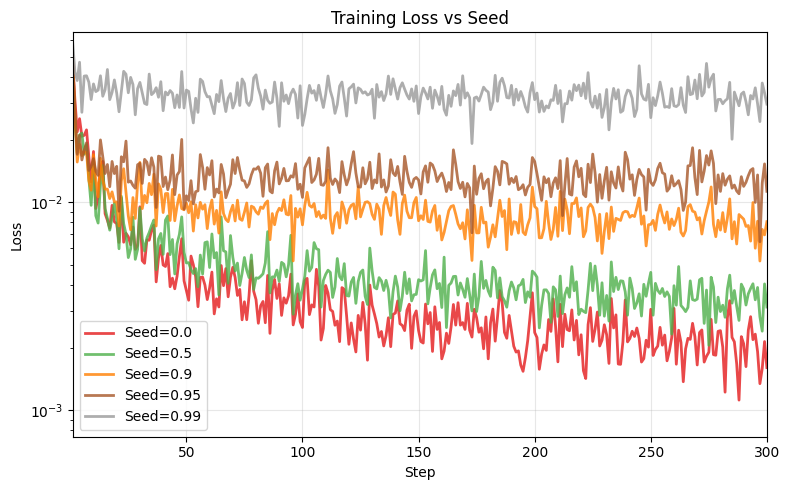


Final Results Summary:
Seed=0.0  --  Final Loss: 0.001603
Seed=0.5  --  Final Loss: 0.003134
Seed=0.9  --  Final Loss: 0.008060
Seed=0.95  --  Final Loss: 0.011285
Seed=0.99  --  Final Loss: 0.029638


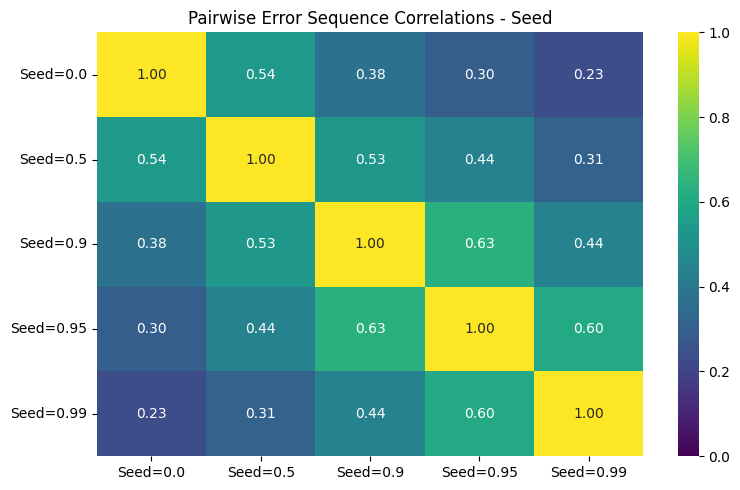

In [27]:
plot_1var_ablation_results(results, 'Seed', figsize=(8, 5))
plt.show()


n_error_entries = len(results[list(results.keys())[0]]['errors'])
n_entries_to_keep = int(n_error_entries * 0.1)
final_results = {
    ablation_key: {'errors': ablation_results['errors'][-n_entries_to_keep:]}
    for ablation_key, ablation_results in results.items()
}
plot_1var_error_correlations(final_results, 'Seed', figsize=(8, 5))
plt.show()

## Different activations

In [13]:
batch_size = 1

n_layers = 3
hidden_dim = 100
activation_classes = [nn.ReLU, nn.SiLU, nn.Tanh, LTU, SinActivation, nn.LeakyReLU, nn.SELU, nn.Sigmoid]

# Run experiments
results = {}
for activation_cls in activation_classes:
    print(f"\nTraining model with {activation_cls.__name__} activation...")
    
    # Create layer sizes
    layer_sizes = [input_dim] + [hidden_dim] * (n_layers - 1) + [outputs.shape[1]]
    # Create model
    model = create_mlp(layer_sizes, activation_cls, seed=7292025)
    learning_rate = 0.02 / hidden_dim ** 0.5
    
    # Train model
    losses = train_model(
        model, inputs, outputs,
        repr_step_size = learning_rate,
        batch_size = 1,
        log_freq = 200,
        print_freq = 2000,
    )
    
    # Store results
    results[activation_cls.__name__] = losses


Training model with ReLU activation...
Step 2000: Loss = 0.023605
Step 4000: Loss = 0.010028
Step 6000: Loss = 0.007271
Step 8000: Loss = 0.005930
Step 10000: Loss = 0.004717
Step 12000: Loss = 0.004140
Step 14000: Loss = 0.004055
Step 16000: Loss = 0.003642
Step 18000: Loss = 0.003408
Step 20000: Loss = 0.003191
Step 22000: Loss = 0.003504
Step 24000: Loss = 0.002968
Step 26000: Loss = 0.002686
Step 28000: Loss = 0.002510
Step 30000: Loss = 0.002742
Step 32000: Loss = 0.002494
Step 34000: Loss = 0.002561
Step 36000: Loss = 0.002518
Step 38000: Loss = 0.002757
Step 40000: Loss = 0.002186
Step 42000: Loss = 0.002246
Step 44000: Loss = 0.002506
Step 46000: Loss = 0.002300
Step 48000: Loss = 0.002377
Step 50000: Loss = 0.002228
Step 52000: Loss = 0.002164
Step 54000: Loss = 0.002048
Step 56000: Loss = 0.002144


Step 58000: Loss = 0.002088
Step 60000: Loss = 0.001995

Training model with SiLU activation...
Step 2000: Loss = 0.024980
Step 4000: Loss = 0.011832
Step 6000: Loss = 0.009581
Step 8000: Loss = 0.007852
Step 10000: Loss = 0.007654
Step 12000: Loss = 0.005451
Step 14000: Loss = 0.005031
Step 16000: Loss = 0.004058
Step 18000: Loss = 0.004433
Step 20000: Loss = 0.003634
Step 22000: Loss = 0.004076
Step 24000: Loss = 0.003617
Step 26000: Loss = 0.003548
Step 28000: Loss = 0.003054
Step 30000: Loss = 0.003008
Step 32000: Loss = 0.003120
Step 34000: Loss = 0.003067
Step 36000: Loss = 0.003037
Step 38000: Loss = 0.002909
Step 40000: Loss = 0.002703
Step 42000: Loss = 0.002670
Step 44000: Loss = 0.003003
Step 46000: Loss = 0.002655
Step 48000: Loss = 0.002573
Step 50000: Loss = 0.002525
Step 52000: Loss = 0.002358
Step 54000: Loss = 0.002265
Step 56000: Loss = 0.002156
Step 58000: Loss = 0.002123
Step 60000: Loss = 0.002484

Training model with Tanh activation...
Step 2000: Loss = 0.034170
S

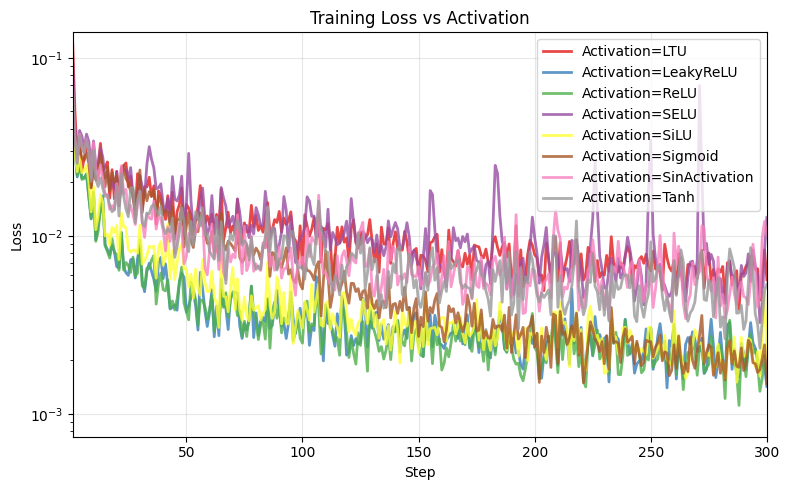


Final Results Summary:
Activation=LTU  --  Final Loss: 0.005663
Activation=LeakyReLU  --  Final Loss: 0.001427
Activation=ReLU  --  Final Loss: 0.001603
Activation=SELU  --  Final Loss: 0.012678
Activation=SiLU  --  Final Loss: 0.002082
Activation=Sigmoid  --  Final Loss: 0.001475
Activation=SinActivation  --  Final Loss: 0.010026
Activation=Tanh  --  Final Loss: 0.005367


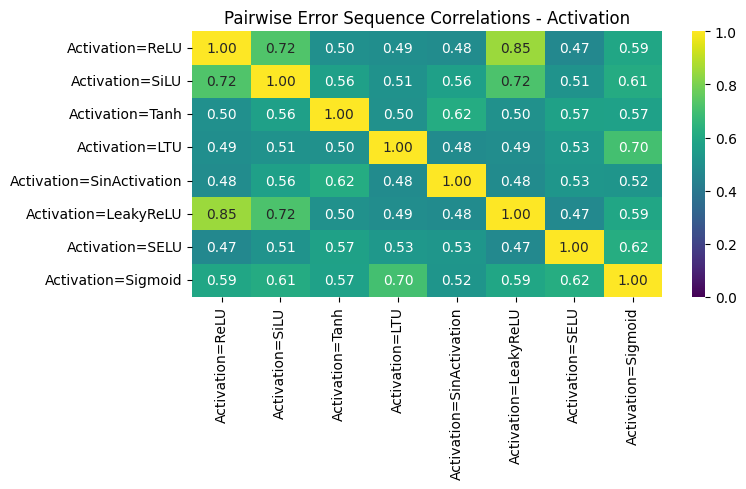

In [ ]:
plot_1var_ablation_results(results, 'Activation', figsize=(8, 5))
plt.show()

n_error_entries = len(results[list(results.keys())[0]]['errors'])
n_entries_to_keep = int(n_error_entries * 0.1)
final_results = {
    ablation_key: {'errors': ablation_results['errors'][-n_entries_to_keep:]}
    for ablation_key, ablation_results in results.items()
}
plot_1var_error_correlations(final_results, 'Activation', figsize=(8, 5))
plt.show()

## Different sparsity rates

In [15]:
batch_size = 1

n_layers = 3
hidden_dim = 100
activation_cls = nn.ReLU
sparsity_rates = [0.0, 0.5, 0.9, 0.95, 0.99]

# Run experiments
results = {}
for sparsity_rate in sparsity_rates:
    print(f"\nTraining model with {sparsity_rate} sparsity rate...")
    
    # Create layer sizes
    expanded_hidden_dim = int(round((hidden_dim**2 / (1 - sparsity_rate))**0.5, 4))
    layer_sizes = [input_dim] + [expanded_hidden_dim] * (n_layers - 1) + [outputs.shape[1]]
    
    # Create model
    model = create_mlp(
        layer_sizes,
        activation_cls,
        seed=7292025,
        sparsity_rate = sparsity_rate,
        small_world_sparsity = False,
    )
    learning_rate = 0.02 / (expanded_hidden_dim * (1.0 - sparsity_rate)) ** 0.5
    
    # Train model
    losses = train_model(
        model, inputs, outputs,
        repr_step_size = learning_rate,
        batch_size = 1,
        log_freq = 200,
        print_freq = 2000,
    )
    
    # Store results
    results[sparsity_rate] = losses


Training model with 0.0 sparsity rate...
Step 2000: Loss = 0.023605
Step 4000: Loss = 0.010028
Step 6000: Loss = 0.007271
Step 8000: Loss = 0.005930
Step 10000: Loss = 0.004717
Step 12000: Loss = 0.004140
Step 14000: Loss = 0.004055
Step 16000: Loss = 0.003642
Step 18000: Loss = 0.003408
Step 20000: Loss = 0.003191
Step 22000: Loss = 0.003504
Step 24000: Loss = 0.002968
Step 26000: Loss = 0.002686
Step 28000: Loss = 0.002510
Step 30000: Loss = 0.002742
Step 32000: Loss = 0.002494
Step 34000: Loss = 0.002561
Step 36000: Loss = 0.002518
Step 38000: Loss = 0.002757
Step 40000: Loss = 0.002186
Step 42000: Loss = 0.002246
Step 44000: Loss = 0.002506
Step 46000: Loss = 0.002300
Step 48000: Loss = 0.002377
Step 50000: Loss = 0.002228
Step 52000: Loss = 0.002164
Step 54000: Loss = 0.002048
Step 56000: Loss = 0.002144
Step 58000: Loss = 0.002088
Step 60000: Loss = 0.001995

Training model with 0.5 sparsity rate...
Step 2000: Loss = 0.020568
Step 4000: Loss = 0.010341
Step 6000: Loss = 0.008153

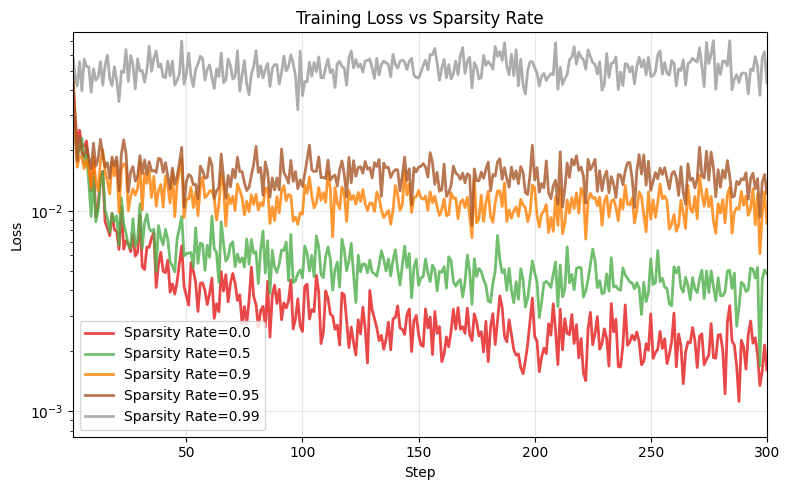


Final Results Summary:
Sparsity Rate=0.0  --  Final Loss: 0.001603
Sparsity Rate=0.5  --  Final Loss: 0.004848
Sparsity Rate=0.9  --  Final Loss: 0.008648
Sparsity Rate=0.95  --  Final Loss: 0.012207
Sparsity Rate=0.99  --  Final Loss: 0.043367


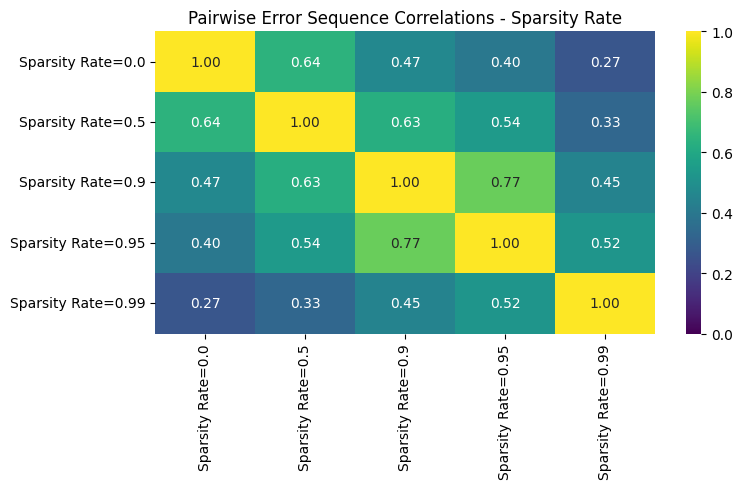

In [ ]:
plot_1var_ablation_results(results, 'Sparsity Rate', figsize=(8, 5))
plt.show()

n_error_entries = len(results[list(results.keys())[0]]['errors'])
n_entries_to_keep = int(n_error_entries * 0.1)
final_results = {
    ablation_key: {'errors': ablation_results['errors'][-n_entries_to_keep:]}
    for ablation_key, ablation_results in results.items()
}
plot_1var_error_correlations(final_results, 'Sparsity Rate', figsize=(8, 5))
plt.show()

## Different small world sparsity rates

In [17]:
batch_size = 1

n_layers = 3
hidden_dim = 100
activation_cls = nn.ReLU
sparsity_rates = [0.0, 0.5, 0.9, 0.95, 0.99]

# Run experiments
results = {}
for sparsity_rate in sparsity_rates:
    print(f"\nTraining model with {sparsity_rate} sparsity rate...")
    
    # Create layer sizes
    expanded_hidden_dim = int(round((hidden_dim**2 / (1 - sparsity_rate))**0.5, 4))
    layer_sizes = [input_dim] + [expanded_hidden_dim] * (n_layers - 1) + [outputs.shape[1]]
    
    # Create model
    model = create_mlp(
        layer_sizes,
        activation_cls,
        seed = 7292025,
        sparsity_rate = sparsity_rate,
        small_world_sparsity = True,
    )
    learning_rate = 0.02 / (expanded_hidden_dim * (1.0 - sparsity_rate)) ** 0.5
    
    # Train model
    losses = train_model(
        model, inputs, outputs,
        repr_step_size = learning_rate,
        batch_size = 1,
        log_freq = 200,
        print_freq = 2000,
    )
    
    # Store results
    results[sparsity_rate] = losses


Training model with 0.0 sparsity rate...
Step 2000: Loss = 0.023605
Step 4000: Loss = 0.010028
Step 6000: Loss = 0.007271
Step 8000: Loss = 0.005930
Step 10000: Loss = 0.004717
Step 12000: Loss = 0.004140
Step 14000: Loss = 0.004055
Step 16000: Loss = 0.003642
Step 18000: Loss = 0.003408
Step 20000: Loss = 0.003191
Step 22000: Loss = 0.003504
Step 24000: Loss = 0.002968
Step 26000: Loss = 0.002686
Step 28000: Loss = 0.002510
Step 30000: Loss = 0.002742
Step 32000: Loss = 0.002494
Step 34000: Loss = 0.002561
Step 36000: Loss = 0.002518
Step 38000: Loss = 0.002757
Step 40000: Loss = 0.002186
Step 42000: Loss = 0.002246
Step 44000: Loss = 0.002506
Step 46000: Loss = 0.002300
Step 48000: Loss = 0.002377
Step 50000: Loss = 0.002228
Step 52000: Loss = 0.002164
Step 54000: Loss = 0.002048
Step 56000: Loss = 0.002144
Step 58000: Loss = 0.002088
Step 60000: Loss = 0.001995

Training model with 0.5 sparsity rate...
Step 2000: Loss = 0.020396
Step 4000: Loss = 0.009534
Step 6000: Loss = 0.007207

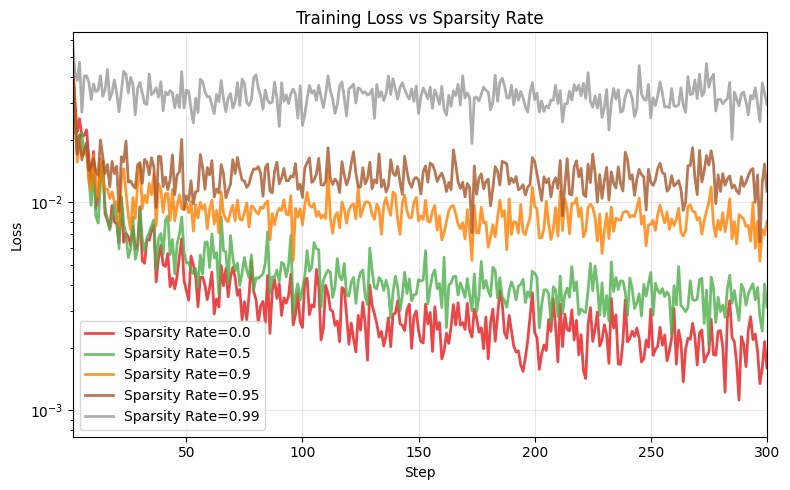


Final Results Summary:
Sparsity Rate=0.0  --  Final Loss: 0.001603
Sparsity Rate=0.5  --  Final Loss: 0.003134
Sparsity Rate=0.9  --  Final Loss: 0.008060
Sparsity Rate=0.95  --  Final Loss: 0.011285
Sparsity Rate=0.99  --  Final Loss: 0.029638


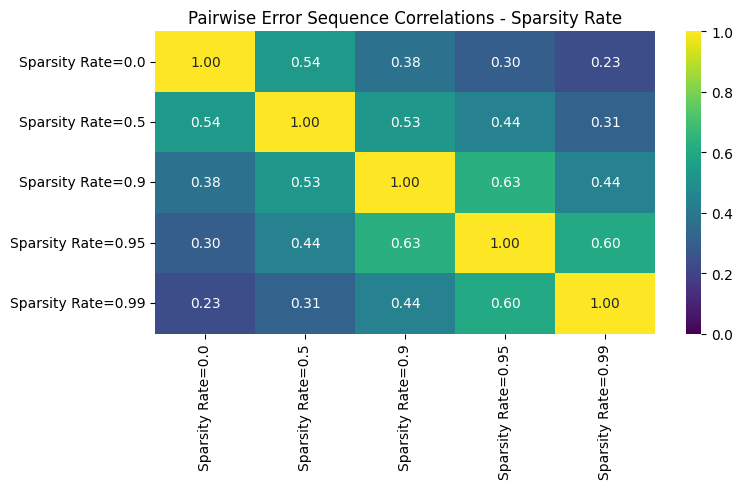

In [29]:
plot_1var_ablation_results(results, 'Sparsity Rate', figsize=(8, 5))
plt.show()

n_error_entries = len(results[list(results.keys())[0]]['errors'])
n_entries_to_keep = int(n_error_entries * 0.1)
final_results = {
    ablation_key: {'errors': ablation_results['errors'][-n_entries_to_keep:]}
    for ablation_key, ablation_results in results.items()
}
plot_1var_error_correlations(final_results, 'Sparsity Rate', figsize=(8, 5))
plt.show()